# Comparing n data points to label scores

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
# import F1s
scores = pd.read_csv(f'/home/dveytia/ORO-map-relevance/outputs/summary_model_scores.csv')
scores = scores[['model','label name', 'F1', 'F1 macro', 'F1 - label']]

# combine different types of F1 scores into just one
def combine_f1(row):
    if pd.isna(row['F1 macro']) == False:
        row['F1'] = row['F1 macro']
    if pd.isna(row['F1 - label']) == False:
        row['F1'] = row['F1 - label']
    return row['F1']

scores['F1'] = scores.apply (lambda row: combine_f1(row), axis=1)

scores = scores[['model','label name', 'F1']]


print(scores.head(8))

                 model label name        F1
0               screen        NaN  0.702171
1   climate_mitigation        NaN  0.802477
2             Forecast        NaN  0.559951
3       impact_ncp.Any        NaN  0.464714
4        impact_nature        NaN  0.404465
5          blue_carbon        NaN  0.894561
6  biodiversity_metric        NaN  0.535073
7          restoration        NaN  0.605373


In [7]:
# For each of these labels, tabulate the number of data points


# Set up
# load in the coding dataset
codedVariablesTxt = '/home/dveytia/ORO-map-relevance/data/seen/all-coding-format-distilBERT-simplifiedMore.txt'
seen_df = pd.read_csv(codedVariablesTxt, delimiter='\t')
seen_df = seen_df.rename(columns={'analysis_id':'id'})

# Add empty column to fill with number of data points
scores['n'] = pd.Series(dtype='int') 



# Loop through the rows
for i in scores.index:
    
    # the variable and label corresponding to that row
    var = scores['model'][i]
    val = scores['label name'][i]
    
    # check if the variable name is in the columns of the data frame
    targets = [x for x in seen_df.columns if var in x]
    
    # the length of matches has to be > 0 to continue
    if len(targets) > 0:
        
        # if there are no individual labels, sum all of the columns for that variable
        if pd.isna(val) == True:
            sums = seen_df[targets].sum(axis=1) # sum
            sums.loc[sums > 1] = 1 # if > 1, set to 1
            scores.loc[[i], 'n'] = sum(sums)
                
        # if there are individual labels, subset to that column and then sum
        else:
            if var + '.' + val in seen_df:
                scores.loc[[i], 'n'] = sum(seen_df[var + '.' + val])
                
    if var == 'screen':
        screen_txt = pd.read_csv('/home/dveytia/ORO-map-relevance/data/seen/all-screen-results_screenExcl-codeIncl.txt', delimiter='\t')
        scores.loc[[i], 'n'] = len(screen_txt)
            

                 
print(scores.head(8))

                 model label name        F1       n
0               screen        NaN  0.702171  2752.0
1   climate_mitigation        NaN  0.802477   305.0
2             Forecast        NaN  0.559951   127.0
3       impact_ncp.Any        NaN  0.464714   134.0
4        impact_nature        NaN  0.404465   228.0
5          blue_carbon        NaN  0.894561    91.0
6  biodiversity_metric        NaN  0.535073   167.0
7          restoration        NaN  0.605373   103.0


In [8]:
# save
scores.to_csv(f'/home/dveytia/ORO-map-relevance/outputs/compare_n_to_score.csv', index=False)

## Visualize the relationship

For how to fit the model, look here: https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

In [16]:
## Organize data
scores2 = scores[scores['n'] > 0] 
scores2 = scores2.sort_values(by=['n'])
x_data = scores2['n']
y_data = scores2['F1']

## Fit the model
def func_model(x, h):
    return x/(x+h) #return 1-np.exp(-k * x)

popt, pcov = curve_fit(func_model, x_data, y_data)


In [17]:
## Explore the results

# compute standard deviation
perr = np.sqrt(np.diag(pcov)) 
print("h = %6.2f +/- %4.2f" % (popt, perr)) 

# determination coefficient
R2 = np.sum((func_model(x_data, popt) - y_data.mean())**2) / np.sum((y_data - y_data.mean())**2)
print("r^2 = %10.6f" % R2)

h = 103.67 +/- 13.79
r^2 =   0.673845


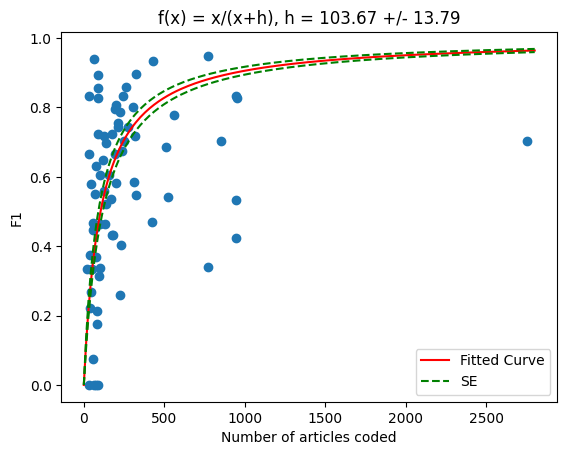

In [31]:
## Plot
plt.scatter(x_data, y_data) # original scatter

# New x values for smoother line plotting
x = np.linspace(0, 2800, 200)

# add fitted curve
plt.plot(x, func_model(x, popt), 'r-', label="Fitted Curve")

# add curves +/- se
plt.plot(x, func_model(x, popt + perr), 'g--', label = "SE")
plt.plot(x, func_model(x, popt - perr), 'g--')

plt.legend()
plt.xlabel("Number of articles coded")
plt.ylabel("F1") 
plt.title("f(x) = x/(x+h), h = %6.2f +/- %4.2f" % (popt, perr))
plt.show()

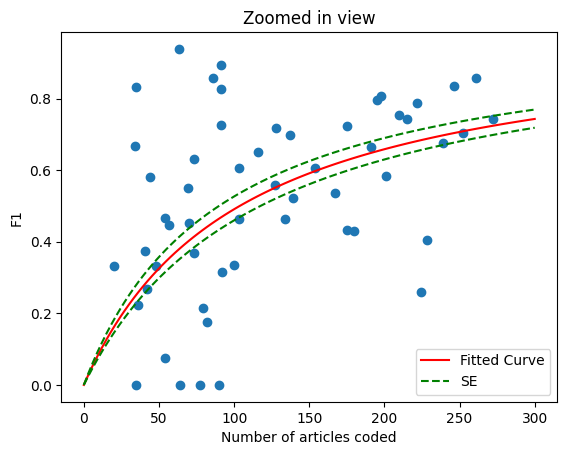

In [33]:
## Plot again, but over smaller range of n
scores3 = scores2[scores2['n'] < 300] 
x_data3 = scores3['n']
y_data3 = scores3['F1']

plt.scatter(x_data3, y_data3)


# New x values for smoother line plotting
x = np.linspace(0, 300, 100)

# add fitted curve
plt.plot(x, func_model(x, popt), 'r-', label="Fitted Curve")

# add curves +/- se
plt.plot(x, func_model(x, popt + perr), 'g--', label = "SE")
plt.plot(x, func_model(x, popt - perr), 'g--')

plt.legend()
plt.xlabel("Number of articles coded")
plt.ylabel("F1") 
plt.title("Zoomed in view")
plt.show()
